<a href="https://colab.research.google.com/github/DulithMH/Credit-Risk-Prediction-ML/blob/main/credit_card_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [40]:
import kagglehub
path = kagglehub.dataset_download("laotse/credit-risk-dataset")

Using Colab cache for faster access to the 'credit-risk-dataset' dataset.


First, let's see what files are inside the `path` directory that `kagglehub` downloaded:

In [41]:
import os
print(os.listdir(path))

['credit_risk_dataset.csv']


Assuming `credit_risk_dataset.csv` is the data file, we can load it into a pandas DataFrame:

In [42]:
df = pd.read_csv(os.path.join(path, 'credit_risk_dataset.csv'))
display(df.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


And now, let's get some descriptive statistics for the numerical columns:

In [43]:
display(df.describe())

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


We observed missing values in `person_emp_length` and `loan_int_rate`. Let's fill these missing values with the median of their respective columns.

In [44]:
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

# Verify that missing values have been handled
print(df.isnull().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


Let's check the DataFrame's information to see column names, non-null counts, and data types:

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


Let's re-examine the descriptive statistics to pinpoint the outliers in `person_age` and `person_emp_length`.

In [46]:
display(df[['person_age', 'person_emp_length']].describe())

,person_age,person_emp_length
count,32581.000000,32581.000000
mean,27.734600,4.767994
std,6.348078,4.087372
min,20.000000,0.000000
25%,23.000000,2.000000
50%,26.000000,4.000000
75%,30.000000,7.000000
max,144.000000,123.000000


As observed, `person_age` has a maximum of 144 years, which is highly improbable. Similarly, `person_emp_length` has a maximum of 123 years. These are clearly outliers that need to be handled. A common approach is to cap these values at a more reasonable threshold. For `person_age`, a typical maximum age in credit risk analysis might be around 90-100 years. For `person_emp_length`, perhaps capping it at 50-60 years would be appropriate. Let's cap `person_age` at 90 and `person_emp_length` at 60.

In [47]:
# Cap person_age at 90 years
df['person_age'] = df['person_age'].apply(lambda x: 90 if x > 90 else x)

# Cap person_emp_length at 60 years
df['person_emp_length'] = df['person_emp_length'].apply(lambda x: 60 if x > 60 else x)

# Verify the changes
display(df[['person_age', 'person_emp_length']].describe())

,person_age,person_emp_length
count,32581.000000,32581.000000
mean,27.727479,4.764126
std,6.251034,4.004465
min,20.000000,0.000000
25%,23.000000,2.000000
50%,26.000000,4.000000
75%,30.000000,7.000000
max,90.000000,60.000000


Let's identify the categorical columns and examine their unique values to determine the best encoding strategy.

In [48]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"Unique values in '{col}': {df[col].unique()}")
    print(f"Number of unique values in '{col}': {df[col].nunique()}\n")

Unique values in 'person_home_ownership': ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Number of unique values in 'person_home_ownership': 4

Unique values in 'loan_intent': ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
Number of unique values in 'loan_intent': 6

Unique values in 'loan_grade': ['D' 'B' 'C' 'A' 'E' 'F' 'G']
Number of unique values in 'loan_grade': 7

Unique values in 'cb_person_default_on_file': ['Y' 'N']
Number of unique values in 'cb_person_default_on_file': 2



Let's re-check for any missing values in the DataFrame:

In [49]:
print(df.isnull().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


Now, let's apply one-hot encoding to the categorical columns. We'll use `pd.get_dummies` for this, which will create new binary columns for each category, effectively converting our categorical data into a numerical format.

In [50]:
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Display the first few rows of the DataFrame with the new encoded columns
display(df.head())

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,60.0,35000,16.02,1,0.59,3,False,False,...,False,True,False,False,False,True,False,False,False,True
1,21,9600,5.0,1000,11.14,0,0.10,2,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,3,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,True,False,False,False,True,False,False,False,False,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,True,False,False,False,True,False,False,False,False,True


To check for outliers in numerical columns, we can use box plots. This visualization helps to show the distribution of the data and highlight any values that fall significantly outside the typical range.

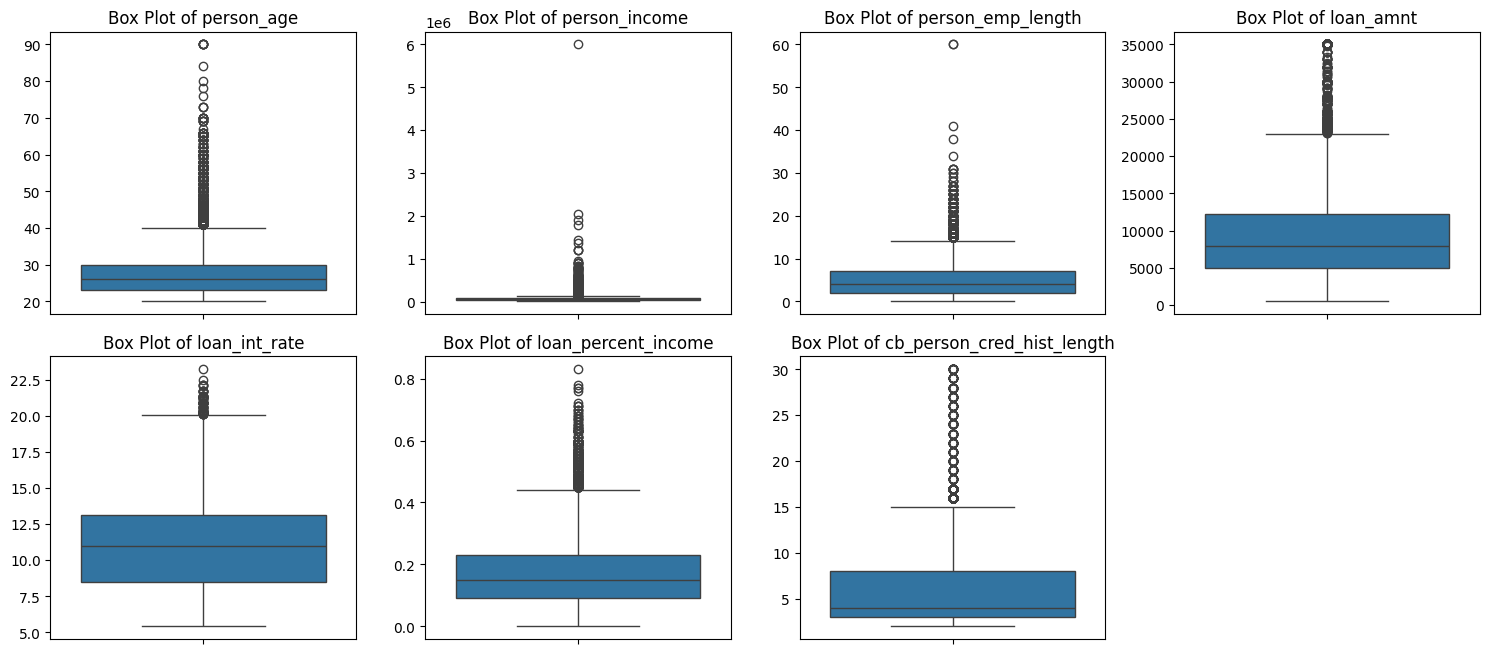

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for outlier detection
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Exclude 'loan_status' if it's the target variable and not a feature to check for outliers
# If 'loan_status' should be treated as a numerical feature for outlier detection, remove this line
if 'loan_status' in numerical_cols:
    numerical_cols = numerical_cols.drop('loan_status')

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)  # Adjust subplot grid as needed
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

Let's create histograms for the numerical columns to better understand their distribution and identify any skewness or unusual patterns.

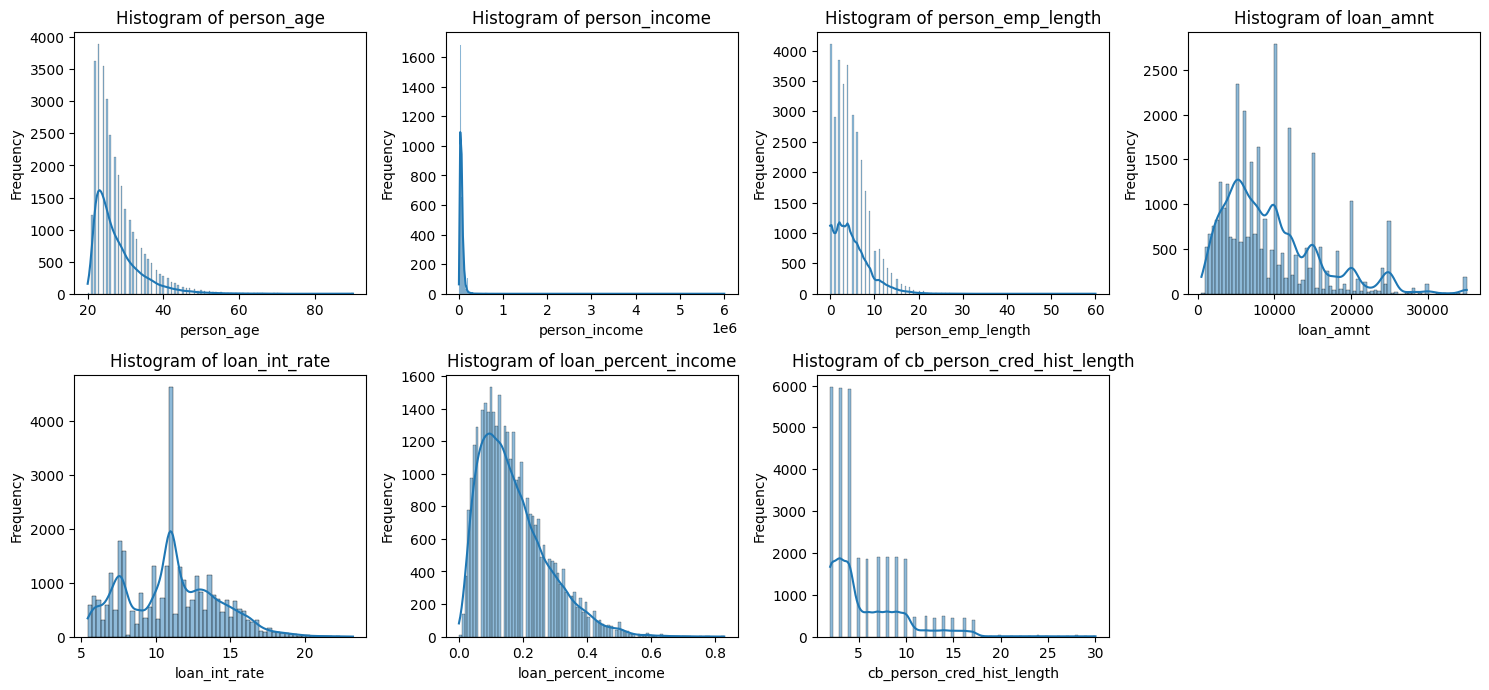

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Exclude 'loan_status' if it's the target variable
if 'loan_status' in numerical_cols:
    numerical_cols = numerical_cols.drop('loan_status')

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)  # Adjust subplot grid as needed
    sns.histplot(df[col], kde=True) # kde=True adds a kernel density estimate curve
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

To reduce the skewness in `person_income` and `loan_amnt`, we will apply a `np.log1p()` transformation. This is particularly useful for right-skewed data as it compresses the range of values and can make the distribution more symmetrical.

In [53]:
df['person_income'] = np.log1p(df['person_income'])
df['loan_amnt'] = np.log1p(df['loan_amnt'])

# Display the first few rows of the DataFrame to show the transformed columns
display(df.head())

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,10.985310,60.0,10.463132,16.02,1,0.59,3,False,False,...,False,True,False,False,False,True,False,False,False,True
1,21,9.169623,5.0,6.908755,11.14,0,0.10,2,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25,9.169623,1.0,8.612685,12.87,1,0.57,3,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23,11.089821,4.0,10.463132,15.23,1,0.53,2,False,False,...,True,False,False,False,True,False,False,False,False,False
4,24,10.904138,8.0,10.463132,14.27,1,0.55,4,False,False,...,True,False,False,False,True,False,False,False,False,True


Now, let's address the outliers in `person_age` and `person_emp_length` by capping them at their 99th percentiles. This technique, also known as winsorization, helps to reduce the impact of extreme values without removing them entirely.

In [54]:
# Calculate the 99th percentile for 'person_age' and 'person_emp_length'
p_age_99th = df['person_age'].quantile(0.99)
p_emp_length_99th = df['person_emp_length'].quantile(0.99)

# Cap the values at the 99th percentile
df['person_age'] = df['person_age'].apply(lambda x: p_age_99th if x > p_age_99th else x)
df['person_emp_length'] = df['person_emp_length'].apply(lambda x: p_emp_length_99th if x > p_emp_length_99th else x)

# Verify the changes by displaying descriptive statistics for the capped columns
display(df[['person_age', 'person_emp_length']].describe())

,person_age,person_emp_length
count,32581.000000,32581.000000
mean,27.659433,4.727970
std,5.916690,3.849422
min,20.000000,0.000000
25%,23.000000,2.000000
50%,26.000000,4.000000
75%,30.000000,7.000000
max,50.000000,17.000000


Based on `person_emp_length`, let's create a new binary feature called `Is_New_Worker`. We'll consider individuals with `person_emp_length` equal to 0 as 'new workers' (flagged as 1), and others as 0.

In [55]:
df['Is_New_Worker'] = (df['person_emp_length'] == 0).astype(int)

# Display the value counts for the new 'Is_New_Worker' column
display(df['Is_New_Worker'].value_counts())

,count
Is_New_Worker,
0,28476
1,4105


In [56]:
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,Is_New_Worker
0,22.0,10.985310,17.0,10.463132,16.02,1,0.59,3,False,False,...,True,False,False,False,True,False,False,False,True,0
1,21.0,9.169623,5.0,6.908755,11.14,0,0.10,2,False,True,...,False,False,True,False,False,False,False,False,False,0
2,25.0,9.169623,1.0,8.612685,12.87,1,0.57,3,False,False,...,False,False,False,True,False,False,False,False,False,0
3,23.0,11.089821,4.0,10.463132,15.23,1,0.53,2,False,False,...,False,False,False,True,False,False,False,False,False,0
4,24.0,10.904138,8.0,10.463132,14.27,1,0.55,4,False,False,...,False,False,False,True,False,False,False,False,True,0


Let's create a box plot to visualize the distribution of `person_age` for different categories of `cb_person_default_on_file_Y`.

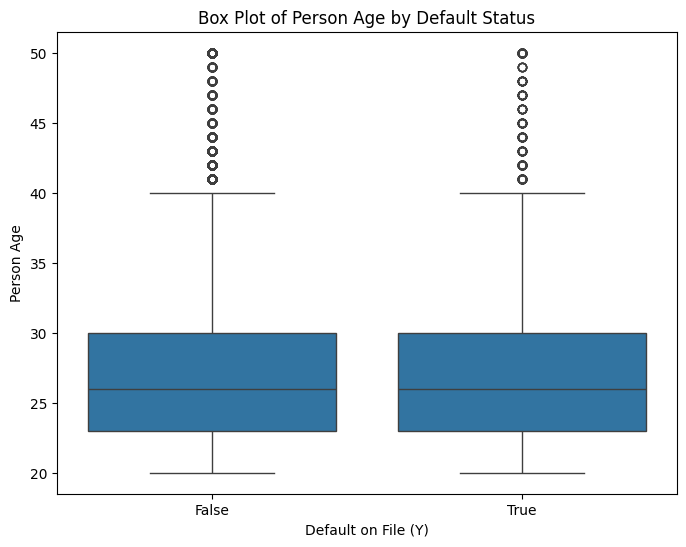

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='cb_person_default_on_file_Y', y='person_age', data=df)
plt.title('Box Plot of Person Age by Default Status')
plt.xlabel('Default on File (Y)')
plt.ylabel('Person Age')
plt.show()

Let's create separate histograms for `person_age` based on the `cb_person_default_on_file_Y` status to see if there are any differences in the age distribution between those who defaulted and those who did not.

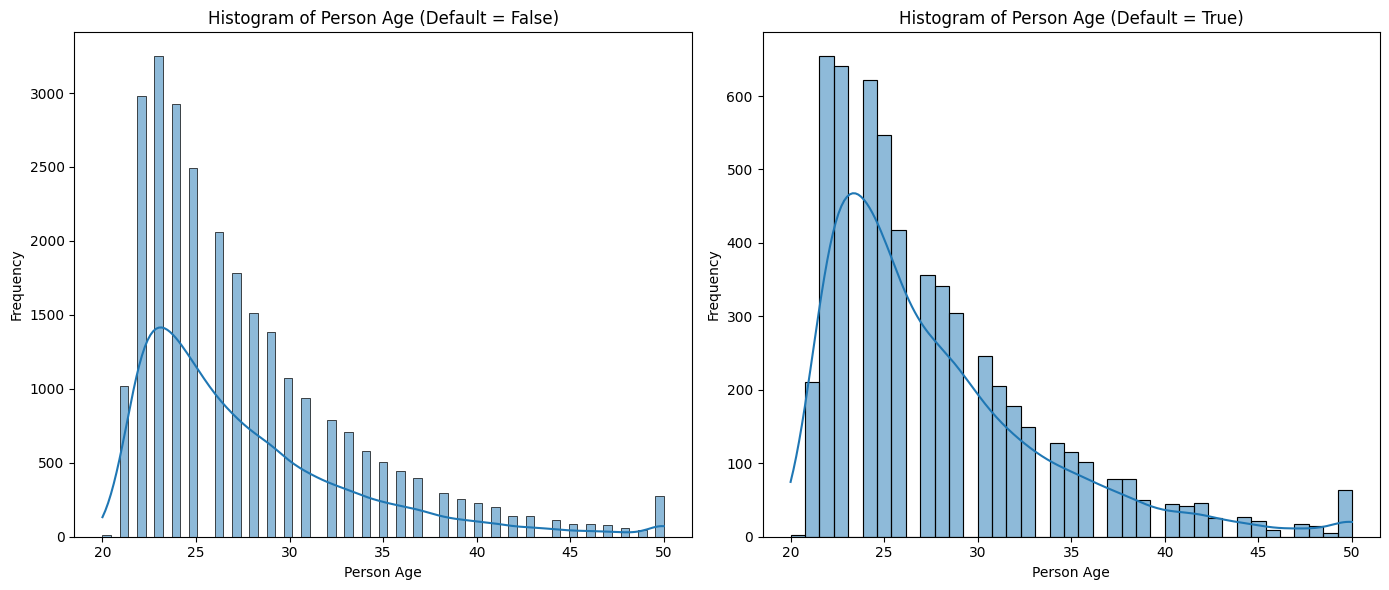

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Histogram for 'cb_person_default_on_file_Y' == False
plt.subplot(1, 2, 1)
sns.histplot(df[df['cb_person_default_on_file_Y'] == False]['person_age'], kde=True)
plt.title('Histogram of Person Age (Default = False)')
plt.xlabel('Person Age')
plt.ylabel('Frequency')

# Histogram for 'cb_person_default_on_file_Y' == True
plt.subplot(1, 2, 2)
sns.histplot(df[df['cb_person_default_on_file_Y'] == True]['person_age'], kde=True)
plt.title('Histogram of Person Age (Default = True)')
plt.xlabel('Person Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

To compare the distribution of `cb_person_default_on_file_Y` across different age groups using bar charts, let's first create age bins for `person_age`. This will categorize ages into ranges, making the bar chart more interpretable.

In [59]:
# Create age bins
age_bins = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
df['age_group'] = pd.cut(df['person_age'], bins=age_bins, right=False, labels=[f'{i}-{j-1}' for i, j in zip(age_bins[:-1], age_bins[1:])])

# Display the value counts for the new 'age_group' column
display(df['age_group'].value_counts().sort_index())

,count
age_group,
18-24,12315
25-29,11193
30-34,4987
35-39,2321
40-44,1005
45-49,420
50-54,340
55-59,0
60-64,0


Now, let's visualize the distribution of `cb_person_default_on_file_Y` across these `age_group` bins using a grouped bar chart. This will clearly show the count of defaulters and non-defaulters within each age range.

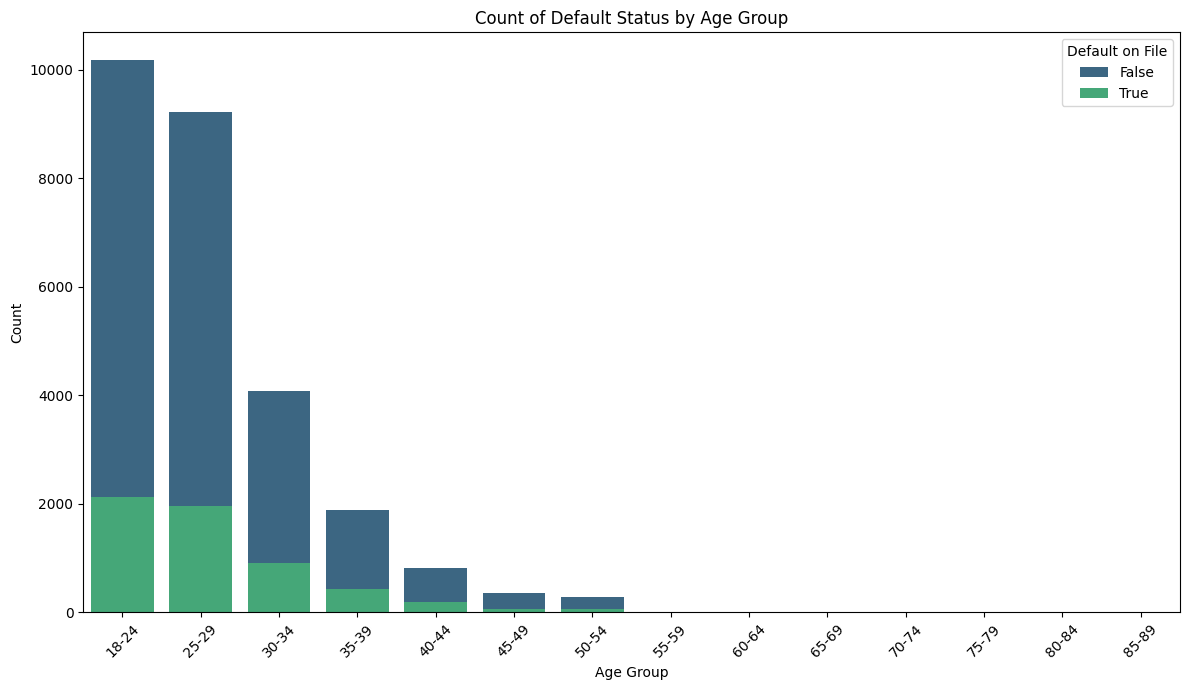

In [60]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='age_group', hue='cb_person_default_on_file_Y', palette='viridis')
plt.title('Count of Default Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Default on File')
plt.tight_layout()
plt.show()

Let's calculate the ratio of `cb_person_default_on_file_Y` for each `age_group`.
This ratio will represent the proportion of individuals in each age group who defaulted.

In [61]:
default_ratio_by_age = df.groupby('age_group')['cb_person_default_on_file_Y'].mean().reset_index()
default_ratio_by_age.rename(columns={'cb_person_default_on_file_Y': 'Default_Ratio'}, inplace=True)

display(default_ratio_by_age)

/tmp/ipython-input-1090391659.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_ratio_by_age = df.groupby('age_group')['cb_person_default_on_file_Y'].mean().reset_index()


,age_group,Default_Ratio
0,18-24,0.173041
1,25-29,0.175824
2,30-34,0.181472
3,35-39,0.183542
4,40-44,0.183085
5,45-49,0.161905
6,50-54,0.185294
7,55-59,NaN
8,60-64,NaN
9,65-69,NaN


Now, let's visualize this default ratio by age group using a bar plot to make the comparison clearer.

/tmp/ipython-input-2126140596.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=default_ratio_by_age, x='age_group', y='Default_Ratio', palette='viridis')


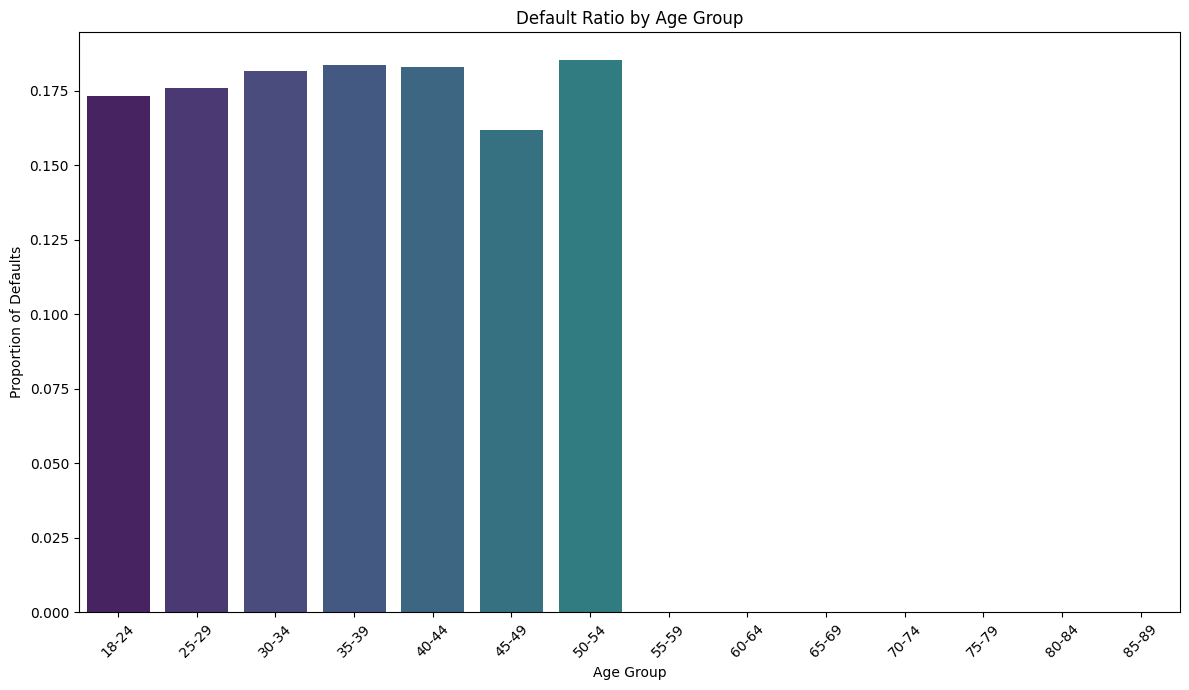

In [62]:
plt.figure(figsize=(12, 7))
sns.barplot(data=default_ratio_by_age, x='age_group', y='Default_Ratio', palette='viridis')
plt.title('Default Ratio by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Defaults')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's calculate the ratio of 'True' and 'False' values in `cb_person_default_on_file_Y` to understand the overall distribution of default status in the dataset.

,Default_Status,Ratio
0,False,0.82367
1,True,0.17633


/tmp/ipython-input-1727424275.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Default_Status', y='Ratio', data=default_status_ratio, palette='viridis')


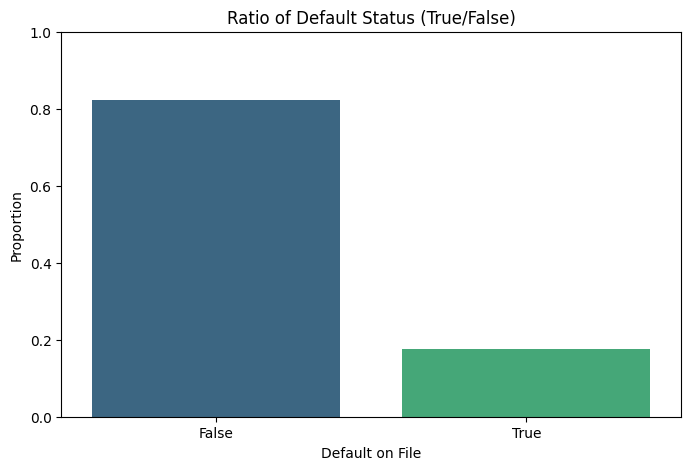

In [63]:
default_status_ratio = df['cb_person_default_on_file_Y'].value_counts(normalize=True).reset_index()
default_status_ratio.columns = ['Default_Status', 'Ratio']
display(default_status_ratio)

plt.figure(figsize=(8, 5))
sns.barplot(x='Default_Status', y='Ratio', data=default_status_ratio, palette='viridis')
plt.title('Ratio of Default Status (True/False)')
plt.xlabel('Default on File')
plt.ylabel('Proportion')
plt.ylim(0, 1) # Ensure y-axis goes from 0 to 1 for proportions
plt.show()

To examine linearity and redundancy among numerical features, let's generate a correlation heatmap. This visualization will show us how strongly each pair of numerical variables is linearly related, highlighting potential multicollinearity (redundancy) which can be important for model building.

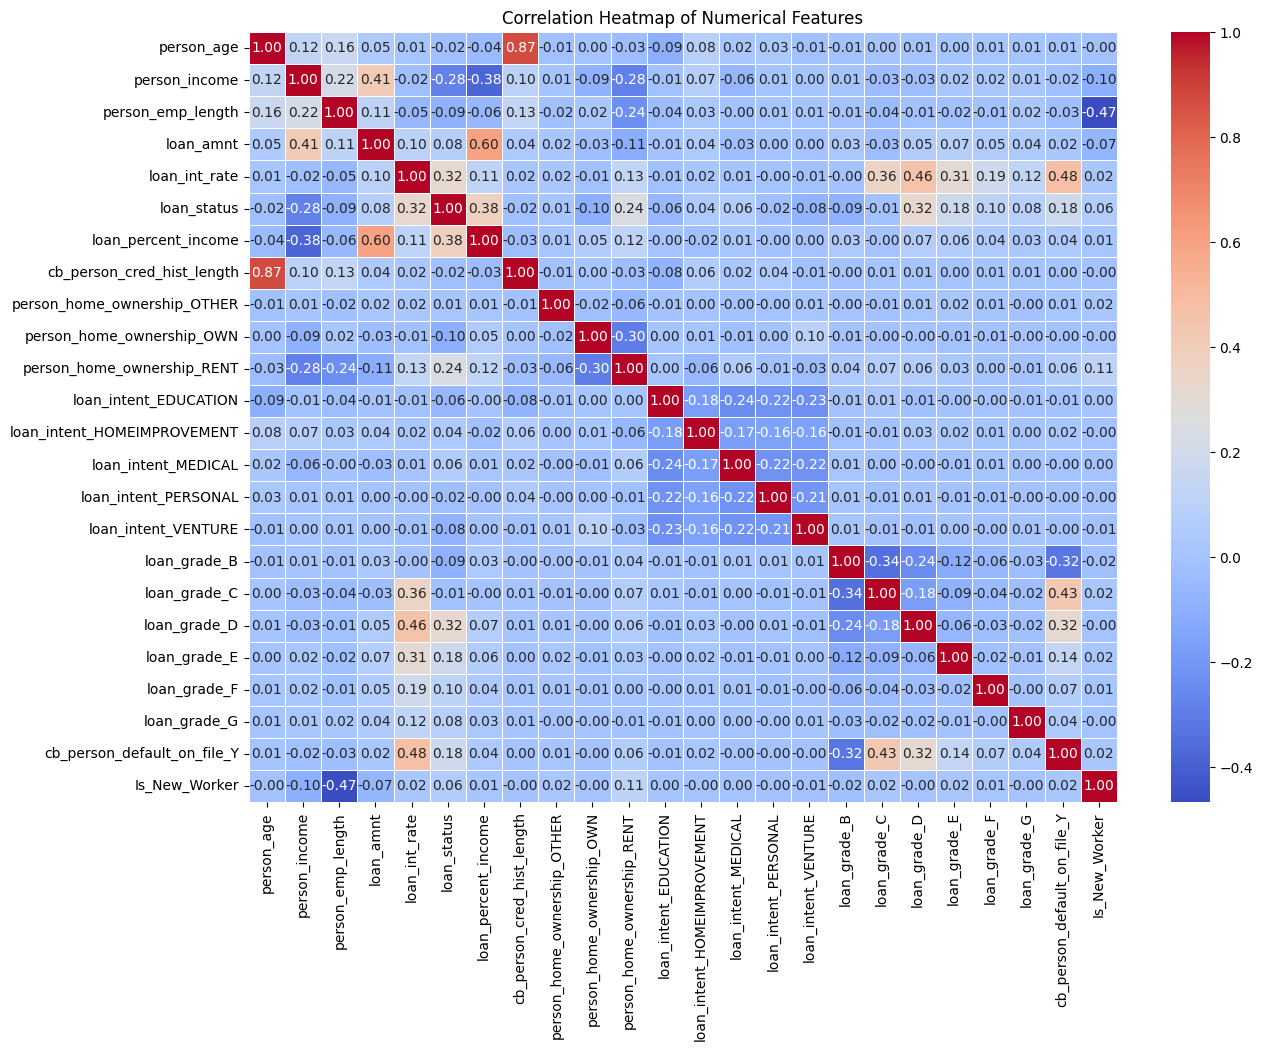

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for numerical columns
correlation_matrix = df.select_dtypes(include=['int64', 'float64', 'bool']).corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

To quantify multicollinearity, let's calculate the Variance Inflation Factor (VIF) for each independent variable. A high VIF value (typically above 5 or 10) indicates that a variable is highly correlated with other variables in the model, which can be problematic for some regression models.

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Drop the target variable 'loan_status' and the 'age_group' column (created for visualization)
X = df.drop(columns=['loan_status', 'age_group'])

# Convert boolean columns to integers (0 and 1) for VIF calculation
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Add a constant to the DataFrame for VIF calculation
X = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values, sorted for easier interpretation
display(vif_data.sort_values(by="VIF", ascending=False))

,feature,VIF
0,const,671.284917
4,loan_amnt,6.245609
6,loan_percent_income,6.036634
5,loan_int_rate,5.578381
2,person_income,4.822234
17,loan_grade_C,4.637221
18,loan_grade_D,4.618382
1,person_age,4.303798
7,cb_person_cred_hist_length,4.226176
16,loan_grade_B,2.767446


In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select only numerical features for VIF
numeric_cols = df.select_dtypes(include=[np.number]).columns
X_vif = df[numeric_cols].drop(columns=['loan_status']) # Don't include the target!

# Add intercept
X_vif_const = add_constant(X_vif)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(len(X_vif_const.columns))]

print(vif_data.sort_values(by="VIF", ascending=False))

                      Feature         VIF
0                       const  586.049478
4                   loan_amnt    6.232462
6         loan_percent_income    6.019659
2               person_income    4.718140
1                  person_age    4.279682
7  cb_person_cred_hist_length    4.220590
3           person_emp_length    1.368371
8               Is_New_Worker    1.287464
5               loan_int_rate    1.018418


In [67]:
# 1. Drop the most redundant variable found in your heatmap
df_reduced = df.drop(columns=['cb_person_cred_hist_length'])

# 2. Re-check VIF on the remaining variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_pd = pd.DataFrame()
    vif_pd["Variable"] = X.columns
    vif_pd["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_pd.sort_values('VIF', ascending=False)

# Use your encoded numerical columns here
print(calculate_vif(df_reduced.select_dtypes(include=[np.number]).drop(columns=['loan_status'])))

              Variable         VIF
3            loan_amnt  871.903831
1        person_income  750.813435
0           person_age   23.580808
5  loan_percent_income   16.309372
4        loan_int_rate   13.809997
2    person_emp_length    3.384783
6        Is_New_Worker    1.470899


Based on the VIF analysis and your instructions, let's drop the identified highly correlated and redundant features: `loan_percent_income`, `cb_person_cred_hist_length`, and all `loan_grade` columns. Then, we will re-evaluate the VIFs.

In [68]:
# Identify loan_grade columns
loan_grade_cols = [col for col in df.columns if 'loan_grade_' in col]

# List of all columns to drop
columns_to_drop = ['loan_percent_income', 'cb_person_cred_hist_length'] + loan_grade_cols

# Drop the columns if they exist
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])

# Recalculate VIFs for the remaining numerical features
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select only numerical features for VIF from the modified DataFrame
X_vif_final = df.select_dtypes(include=[np.number, 'bool']).drop(columns=['loan_status'])

# Convert boolean columns to integers (0 and 1) for VIF calculation
for col in X_vif_final.select_dtypes(include='bool').columns:
    X_vif_final[col] = X_vif_final[col].astype(int)

# Add a constant to the DataFrame for VIF calculation
X_vif_final = add_constant(X_vif_final)

# Calculate VIF for each feature
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_vif_final.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_vif_final.values, i) for i in range(X_vif_final.shape[1])]

# Display the VIF values, sorted for easier interpretation
display(vif_data_final.sort_values(by="VIF", ascending=False))

,feature,VIF
0,const,487.993191
9,loan_intent_EDUCATION,1.810691
11,loan_intent_MEDICAL,1.772631
13,loan_intent_VENTURE,1.760539
12,loan_intent_PERSONAL,1.720246
10,loan_intent_HOMEIMPROVEMENT,1.523652
3,person_emp_length,1.406333
2,person_income,1.382237
5,loan_int_rate,1.333989
8,person_home_ownership_RENT,1.300093


In [69]:
# Define target variable (y) and features (X)
y = df['loan_status']
X = df.drop(columns=['loan_status', 'age_group'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (26064, 15)
X_test shape: (6517, 15)
y_train shape: (26064,)
y_test shape: (6517,)


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Initialize the model with the balanced weight
# This automatically adjusts weights inversely proportional to class frequencies
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 2. Fit the model on your training data
log_reg.fit(X_train, y_train)

# 3. Make predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1] # Probabilities for the ROC-AUC

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Initialize the model with the balanced weight
# This automatically adjusts weights inversely proportional to class frequencies
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 2. Fit the model on your training data
log_reg.fit(X_train, y_train)

# 3. Make predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1] # Probabilities for the ROC-AUC

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      5095
           1       0.47      0.79      0.59      1422

    accuracy                           0.76      6517
   macro avg       0.70      0.77      0.71      6517
weighted avg       0.83      0.76      0.78      6517


Recall (for positive class): 0.7918


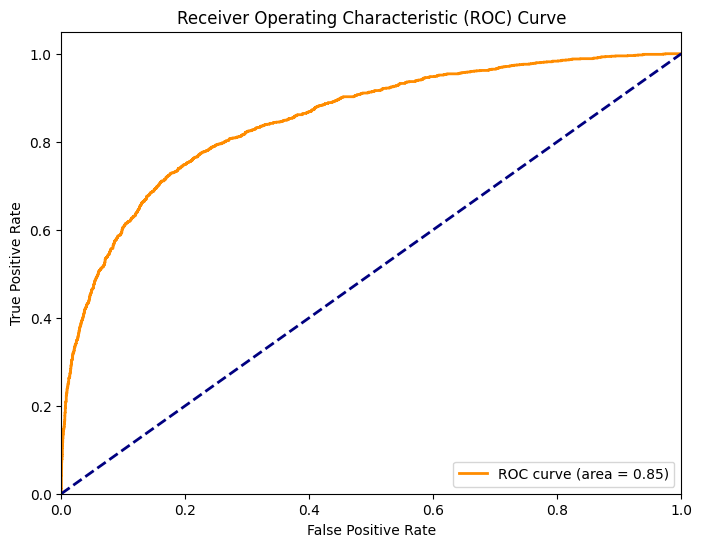

In [72]:
from sklearn.metrics import recall_score, roc_curve, auc
import matplotlib.pyplot as plt

# 4. Evaluate the model

# Get the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate Recall (specifically for the positive class, '1')
recall = recall_score(y_test, y_pred)
print(f"\nRecall (for positive class): {recall:.4f}")

# Plot ROC Curve and calculate AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [73]:
# View the importance of each feature
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

                        Feature  Coefficient
3                     loan_amnt     0.980910
7    person_home_ownership_RENT     0.605117
5   person_home_ownership_OTHER     0.365194
4                 loan_int_rate     0.277001
13  cb_person_default_on_file_Y     0.257025
14                Is_New_Worker     0.208803
9   loan_intent_HOMEIMPROVEMENT     0.120460
2             person_emp_length     0.015074
0                    person_age     0.000262
10          loan_intent_MEDICAL    -0.205019
11         loan_intent_PERSONAL    -0.509993
8         loan_intent_EDUCATION    -0.716542
12          loan_intent_VENTURE    -1.032373
6     person_home_ownership_OWN    -1.527485
1                 person_income    -2.129969


Let's visualize the Confusion Matrix. This will give us a clear picture of how many predictions were correct and incorrect for each class.

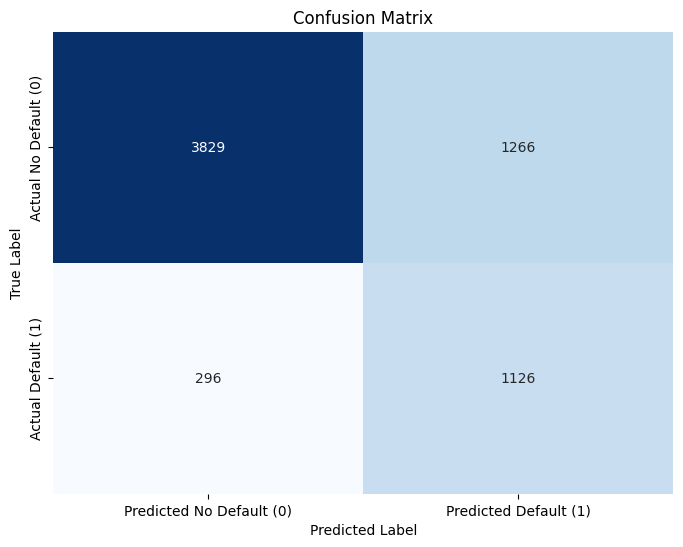

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization with labels
cm_df = pd.DataFrame(cm,
                     index = ['Actual No Default (0)', 'Actual Default (1)'],
                     columns = ['Predicted No Default (0)', 'Predicted Default (1)'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

You can use the trained `log_reg` model to make predictions on new, unseen data. We'll demonstrate this using the `X_test` dataset.

In [75]:
# Predict class labels (0 or 1) for the test set
y_pred_new_data = log_reg.predict(X_test)
display(pd.DataFrame(y_pred_new_data, columns=['Predicted_Loan_Status']).head())

# Predict probabilities for each class for the test set
# The output will be an array where the first column is the probability of class 0, and the second is the probability of class 1
y_proba_new_data = log_reg.predict_proba(X_test)
display(pd.DataFrame(y_proba_new_data, columns=['Prob_No_Default', 'Prob_Default']).head())

,Predicted_Loan_Status
0,0
1,0
2,0
3,0
4,0


,Prob_No_Default,Prob_Default
0,0.529205,0.470795
1,0.755796,0.244204
2,0.964879,0.035121
3,0.643837,0.356163
4,0.925410,0.074590


In [76]:
# Create a DataFrame to compare actual vs. predicted values
comparison_df = pd.DataFrame({'Actual_Loan_Status': y_test, 'Predicted_Loan_Status': y_pred_new_data})
display(comparison_df.head(10))

,Actual_Loan_Status,Predicted_Loan_Status
6616,0,0
21802,0,0
31886,0,0
17799,0,0
5207,0,0
2543,0,0
14816,0,0
10276,0,0
26929,0,0
22964,1,1


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np

In [80]:
# Define a prediction function for Gradio
def predict_default(
    person_age,
    person_income,
    person_emp_length,
    loan_amnt,
    loan_int_rate,
    person_home_ownership_OTHER,
    person_home_ownership_OWN,
    person_home_ownership_RENT,
    loan_intent_EDUCATION,
    loan_intent_HOMEIMPROVEMENT,
    loan_intent_MEDICAL,
    loan_intent_PERSONAL,
    loan_intent_VENTURE,
    cb_person_default_on_file_Y,
    Is_New_Worker
):
    # Apply log1p transformation to person_income and loan_amnt as the model expects them
    person_income_transformed = np.log1p(person_income)
    loan_amnt_transformed = np.log1p(loan_amnt)

    # Create a DataFrame from the input features
    input_data = pd.DataFrame({
        'person_age': [person_age],
        'person_income': [person_income_transformed],
        'person_emp_length': [person_emp_length],
        'loan_amnt': [loan_amnt_transformed],
        'loan_int_rate': [loan_int_rate],
        'person_home_ownership_OTHER': [person_home_ownership_OTHER],
        'person_home_ownership_OWN': [person_home_ownership_OWN],
        'person_home_ownership_RENT': [person_home_ownership_RENT],
        'loan_intent_EDUCATION': [loan_intent_EDUCATION],
        'loan_intent_HOMEIMPROVEMENT': [loan_intent_HOMEIMPROVEMENT],
        'loan_intent_MEDICAL': [loan_intent_MEDICAL],
        'loan_intent_PERSONAL': [loan_intent_PERSONAL],
        'loan_intent_VENTURE': [loan_intent_VENTURE],
        'cb_person_default_on_file_Y': [cb_person_default_on_file_Y],
        'Is_New_Worker': [Is_New_Worker]
    })

    # Ensure boolean columns are correctly typed for the model
    for col in input_data.select_dtypes(include='bool').columns:
        input_data[col] = input_data[col].astype(bool)

    # Make prediction
    prediction = log_reg.predict(input_data)[0]
    probability = log_reg.predict_proba(input_data)[0][1] # Probability of default (class 1)

    # Determine risk status based on probability
    if probability > 0.6:
        risk_status = "High Risk"
    else:
        risk_status = "Low Risk"

    return risk_status, f"{probability:.4f}"


In [82]:
# Get feature ranges for Gradio sliders/numbers from X_train if available, otherwise set reasonable defaults
feature_ranges = {}
for col in X_train.columns:
    if X_train[col].dtype in ['int64', 'float64']:
        # For log-transformed features, inverse transform to get original scale for UI
        if col in ['person_income', 'loan_amnt']:
            feature_ranges[col] = {'min': np.expm1(X_train[col].min()), 'max': np.expm1(X_train[col].max()), 'value': np.expm1(X_train[col].median())}
        else:
            feature_ranges[col] = {'min': X_train[col].min(), 'max': X_train[col].max(), 'value': X_train[col].median()}
    elif X_train[col].dtype == 'bool':
        feature_ranges[col] = {'value': False}

# --- Adjusting initial values for a 'High Risk' scenario ---
feature_ranges['loan_amnt']['value'] = feature_ranges['loan_amnt']['max'] # Maximize loan amount
feature_ranges['loan_int_rate']['value'] = feature_ranges['loan_int_rate']['max'] # Maximize interest rate
feature_ranges['person_income']['value'] = feature_ranges['person_income']['min'] # Minimize income
feature_ranges['person_home_ownership_RENT']['value'] = True # Set home ownership to RENT
feature_ranges['cb_person_default_on_file_Y']['value'] = True # Set default on file to True

# Define Gradio inputs
inputs = [
    gr.Slider(minimum=feature_ranges['person_age']['min'], maximum=feature_ranges['person_age']['max'], value=feature_ranges['person_age']['value'], label="Person Age"),
    gr.Slider(minimum=feature_ranges['person_income']['min'], maximum=feature_ranges['person_income']['max'], value=feature_ranges['person_income']['value'], label="Person Income"),
    gr.Slider(minimum=feature_ranges['person_emp_length']['min'], maximum=feature_ranges['person_emp_length']['max'], value=feature_ranges['person_emp_length']['value'], label="Person Employment Length"),
    gr.Slider(minimum=feature_ranges['loan_amnt']['min'], maximum=feature_ranges['loan_amnt']['max'], value=feature_ranges['loan_amnt']['value'], label="Loan Amount"),
    gr.Slider(minimum=feature_ranges['loan_int_rate']['min'], maximum=feature_ranges['loan_int_rate']['max'], value=feature_ranges['loan_int_rate']['value'], label="Loan Interest Rate"),
    gr.Checkbox(value=feature_ranges['person_home_ownership_OTHER']['value'], label="Home Ownership: Other"),
    gr.Checkbox(value=feature_ranges['person_home_ownership_OWN']['value'], label="Home Ownership: Own"),
    gr.Checkbox(value=feature_ranges['person_home_ownership_RENT']['value'], label="Home Ownership: Rent"),
    gr.Checkbox(value=feature_ranges['loan_intent_EDUCATION']['value'], label="Loan Intent: Education"),
    gr.Checkbox(value=feature_ranges['loan_intent_HOMEIMPROVEMENT']['value'], label="Loan Intent: Home Improvement"),
    gr.Checkbox(value=feature_ranges['loan_intent_MEDICAL']['value'], label="Loan Intent: Medical"),
    gr.Checkbox(value=feature_ranges['loan_intent_PERSONAL']['value'], label="Loan Intent: Personal"),
    gr.Checkbox(value=feature_ranges['loan_intent_VENTURE']['value'], label="Loan Intent: Venture"),
    gr.Checkbox(value=feature_ranges['cb_person_default_on_file_Y']['value'], label="Default on File"),
    gr.Checkbox(value=feature_ranges['Is_New_Worker']['value'], label="Is New Worker")
]

# Define Gradio outputs
outputs = [
    gr.Textbox(label="Risk Status"),
    gr.Textbox(label="Probability of Default")
]

# Create and launch the Gradio interface
interface = gr.Interface(
    fn=predict_default,
    inputs=inputs,
    outputs=outputs,
    title="Credit Risk Prediction",
    description="Enter customer details to predict loan default status."
)

interface.launch(inline=True, share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>